<a href="https://colab.research.google.com/github/anoopsanka/retinal_oct/blob/main/notebooks/OCT_simclr_representation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/anoopsanka/retinal_oct

Cloning into 'retinal_oct'...
remote: Enumerating objects: 298, done.
remote: Counting objects: 100% (298/298), done.
remote: Compressing objects: 100% (210/210), done.
remote: Total 401 (delta 167), reused 189 (delta 84), pack-reused 103
Receiving objects: 100% (401/401), 254.03 MiB | 23.39 MiB/s, done.
Resolving deltas: 100% (202/202), done.


In [ ]:
%%capture
# needed to use rotate....
!pip install -U tensorflow_addons

In [ ]:
%cd retinal_oct

/content/retinal_oct


In [ ]:
import tensorflow_datasets as tfds
from importlib.util import find_spec
if find_spec("core") is None:
    import sys
    sys.path.append('..')
    
from core.datasets import RetinaDataset

In [ ]:
ds_train, ds_train_info = tfds.load('RetinaDataset', split='train', shuffle_files=True, as_supervised=True, with_info=True)
ds_test  = tfds.load('RetinaDataset', split='test', shuffle_files=False, as_supervised=True)

In [ ]:
%cd core/models/simclr

/content/retinal_oct/core/models/simclr


In [ ]:
import os
import random
import numpy as np
import tensorflow as tf

# Set the random seeds
os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
tf.random.set_seed(hash("by removing stochasticity") % 2**32 - 1)

In [ ]:
from data_augmentation import train_classification_aug
from lr_schedule import WarmUpAndCosineDecay
import simclr_model
import tensorflow_addons as tfa

# Pull Sample Weights from Wandb
https://wandb.ai/hisunnytang/OCT-keras-SimCLR


97 % contrastive accuracy & ~ 90 % supervised accuracy
- https://wandb.ai/hisunnytang/OCT-keras-SimCLR/runs/1ipksk06/overview?workspace=user-hisunnytang

In [ ]:
%%capture
pip install wandb

In [ ]:
import wandb
api = wandb.Api()
run = api.run("hisunnytang/OCT-keras-SimCLR/1ipksk06")
run.file("weights.108-0.97.hdf5").download()

<IPython.core.display.Javascript object>

wandb: You can find your API key in your browser here: https://wandb.ai/authorize


wandb: Paste an API key from your profile and hit enter: ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


<_io.TextIOWrapper name='./weights.108-0.97.hdf5' mode='r' encoding='UTF-8'>

In [ ]:
config = run.config

In [ ]:
config

{'IMG_SIZE': 128,
 'batch_size': 128,
 'epochs': 120,
 'ft_proj_selector': 0,
 'hidden_norm': True,
 'learning_rate': 0.01,
 'learning_rate_scaling': 'linear',
 'num_classes': 4,
 'num_examples': 83489,
 'num_proj_layers': 3,
 'proj_head_mode': 'nonlinear',
 'proj_out_dim': 128,
 'resnet_depth': 18,
 'resnet_se_ratio': 0,
 'resnet_sk_ratio': 0,
 'resnet_width_multiplier': 1,
 'temperature': 1,
 'use_blur': True,
 'warmup_epochs': 10}

In [ ]:
from simclr_model import Pretrained_SimCLR_Model

model_loadweights = Pretrained_SimCLR_Model()

In [ ]:
input_shape_base   = (None, config["IMG_SIZE"], config["IMG_SIZE"], 3)
input_shape_simclr = (None, config["IMG_SIZE"], config["IMG_SIZE"], 6)
model_loadweights.base_model.build(input_shape_base)
model_loadweights.build(input_shape_simclr)
model_loadweights.summary()
model_loadweights.load_weights('weights.108-0.97.hdf5')

Model: "pretrained__sim_clr__model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet (Resnet)              multiple                  11190464  
_________________________________________________________________
head_supervised (SupervisedH multiple                  2052      
_________________________________________________________________
projection_head (ProjectionH multiple                  594304    
Total params: 11,786,830
Trainable params: 11,774,788
Non-trainable params: 12,042
_________________________________________________________________


In [ ]:
from data_augmentation import train_classification_aug

def train_data_aug(img, lb):
  xs = []
  for _ in range(2):
    xs.append(train_classification_aug(img, lb, img_size = 128)[0])
  img = tf.concat(xs, -1)
  return img, tf.one_hot(lb, 4)

def val_data_aug(img, lb):
  xs = []
  for _ in range(2):
    xs.append(train_classification_aug(img, lb, img_size = 128)[0])
  img = tf.concat(xs, -1)
  return img, tf.one_hot(lb, 4)

def resize_only(img, lb):
  # img = tf.cast(img, tf.float32)/ 255.
  img = train_classification_aug(img, lb, img_size = 128)[0]
  # img = tf.image.resize(img, (128,128))
  return img, tf.one_hot(lb, 4)

# When `training = False` / making prediction
## Inputs
- X:
  - shape: `[bsz, IMG_SIZE, IMG_SIZE, 3]`

## outputs
- proj:
  - shape: `[bsz, 128]`
- logits:
  - shape: `[bsz, NUM_CLASSES]`

In [ ]:
X, y = next(iter(ds_test.map(resize_only).batch(128)))
proj, logits = model_loadweights.call(X, training=False)

In [ ]:
sum(logits.numpy().argmax(axis=-1) == y.numpy().argmax(axis=-1))

107

In [ ]:
107/128

0.8359375

# During Evaluation/ training
- expects an input with channel dimension of 6

In [ ]:
model_loadweights.compile()

In [ ]:
model_loadweights.evaluate(ds_test.map(train_data_aug).batch(128))

8/8 [==============================] - 6s 579ms/step - contrast_loss: 9.5215 - contrast_acc: 0.7045 - contrast_entropy: 4.7463 - supervised_loss: 0.3536 - supervised_acc: 0.8880


[9.521537780761719,
 0.7045356035232544,
 4.7462897300720215,
 0.3536350429058075,
 0.8880208134651184,
 9.521537780761719,
 0.7045356035232544,
 4.7462897300720215,
 0.3536350429058075,
 0.8880208134651184]

In [ ]:
model_loadweights.evaluate(ds_train.map(train_data_aug).batch(128))

653/653 [==============================] - 4312s 7s/step - contrast_loss: 9.5645 - contrast_acc: 0.7374 - contrast_entropy: 4.8234 - supervised_loss: 0.4571 - supervised_acc: 0.8397


[9.564534187316895,
 0.7374254465103149,
 4.823367595672607,
 0.4570636749267578,
 0.8397344946861267,
 9.564534187316895,
 0.7374254465103149,
 4.823367595672607,
 0.4570636749267578,
 0.8397344946861267]

# Visualize the Projection Head at PCA embedding

In [ ]:
import numpy as np
from sklearn.decomposition import PCA

### Predict Test Set

In [ ]:
proj_testset, logits_testset = model_loadweights.predict(ds_test.map(resize_only).batch(128))
ytest_pred = logits_testset.argmax(axis=-1)

### Normalized the Projection Embedding

In [ ]:
l2 = np.square(proj_testset).mean(axis=-1, keepdims=True)**0.5
proj_normed = proj_testset/ l2
proj_normed_pcas = PCA(n_components=2).fit_transform(proj_normed)

### Retrieve the Test Set Targets

In [ ]:
test_targets = [t.numpy() for t in ds_test.map(lambda img, lb: lb).batch(128)]
test_targets = np.hstack(test_targets)

In [ ]:
print(f" accuracy:  {sum(ytest_pred == test_targets)/ len(test_targets)}")

 accuracy:  0.8894628099173554


In [ ]:
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix

In [ ]:
print(classification_report(test_targets, ytest_pred))

              precision    recall  f1-score   support

           0       0.86      0.95      0.90       242
           1       0.98      0.78      0.87       242
           2       0.94      0.85      0.89       242
           3       0.82      0.99      0.90       242

    accuracy                           0.89       968
   macro avg       0.90      0.89      0.89       968
weighted avg       0.90      0.89      0.89       968



In [ ]:
confusion_matrix(test_targets, ytest_pred)

array([[229,   1,   5,   7],
       [ 18, 188,   7,  29],
       [ 19,   1, 205,  17],
       [  1,   1,   1, 239]])

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

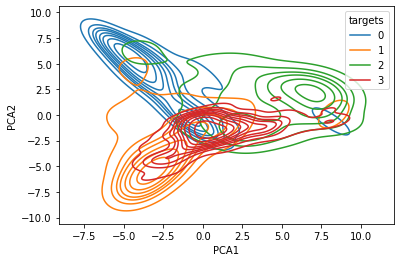

In [ ]:
df = pd.DataFrame(proj_normed_pcas, columns=['PCA1', 'PCA2'])
df['targets'] = test_targets
sns.kdeplot(x ='PCA1', y='PCA2', data= df, hue='targets', palette= sns.color_palette()[0:4] )

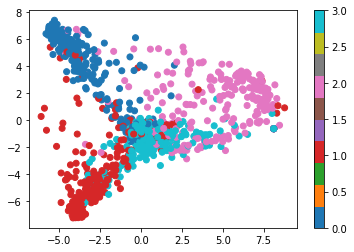

In [ ]:
plt.scatter(df['PCA1'], df['PCA2'], c = test_targets, cmap='tab10')
plt.colorbar()

# Let;s try UMAP

In [ ]:
%%capture
!pip install umap-learn[plot]
!pip install holoviews
!pip install -U ipykernel

In [ ]:
import umap
import umap.plot

In [ ]:
reducer = umap.UMAP( )
umap_embedding = reducer.fit_transform(proj_testset)

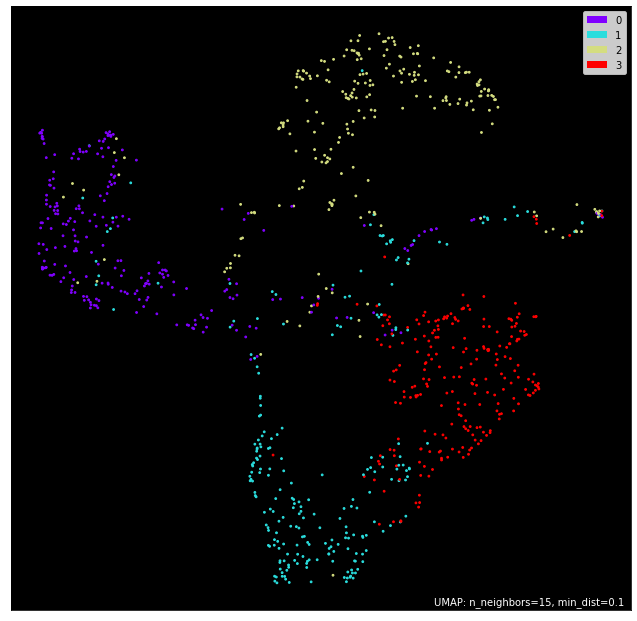

In [ ]:
umap.plot.points(reducer, labels=test_targets, color_key_cmap='Paired', theme='fire' )